<a href="https://colab.research.google.com/github/ShahidNauman/predict-stock-prices/blob/main/predict-stock-prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict Future Stock Prices (Short-Term)

## Objective:
Use historical stock data to predict the next-day stock close price using regression models.

## Dataset:
Stock market data from Yahoo Finance (retrieved using the yfinance Python library)

### 1.   Select a stock (e.g., Apple, Tesla).

In [119]:
# Stock ticker symbol (e.g., AAPL, TSLA)
ticker = 'AAPL'

# Model to train: linear or random_forest.
model_name = 'random_forest'

# Yahoo Finance period string (e.g., 1y, 5y, max)
period = '5y'

# Fraction of data used for testing (chronological split)
test_ratio = 0.2

### 2.   Load historical data using the yfinance library.

In [120]:
import yfinance as yf
import pandas as pd

raw_data = yf.download(ticker, period=period, auto_adjust=False, progress=False)
data = pd.DataFrame(raw_data)
if data.empty:
  raise ValueError(f"No data was returned for ticker '{ticker}'.")
print(data)

Price        Adj Close       Close        High         Low        Open  \
Ticker            AAPL        AAPL        AAPL        AAPL        AAPL   
Date                                                                     
2021-02-22  122.723427  126.000000  129.720001  125.599998  128.009995   
2021-02-23  122.587097  125.860001  126.709999  118.389999  123.760002   
2021-02-24  122.090340  125.349998  125.559998  122.230003  124.940002   
2021-02-25  117.843719  120.989998  126.459999  120.540001  124.680000   
2021-02-26  118.106705  121.260002  124.849998  121.199997  122.589996   
...                ...         ...         ...         ...         ...   
2026-02-13  255.779999  255.779999  262.230011  255.449997  262.010010   
2026-02-17  263.880005  263.880005  266.290009  255.539993  258.049988   
2026-02-18  264.350006  264.350006  266.820007  262.450012  263.600006   
2026-02-19  260.579987  260.579987  264.480011  260.049988  262.600006   
2026-02-20  264.170013  264.170013  26

### 3.   Prepare Dataset. Use features like Open, High, Low, and Volume to predict the next Close price.

In [121]:
from typing import cast

if isinstance(data.columns, pd.MultiIndex):
  if data.columns.nlevels == 2:
    data = data.copy()
    data.columns = data.columns.get_level_values(0)
  else:
    raise ValueError("Unsupported column format returned by data source.")

required_features = ["Open", "High", "Low", "Volume"]
missing_columns = [
    column for column in required_features + ["Close"] if column not in data.columns
]
if missing_columns:
  raise ValueError(f"Dataset is missing required columns: {missing_columns}")

dataset = data.copy()
dataset["TargetClose"] = dataset["Close"].shift(-1)
dataset = dataset.dropna(subset=required_features + ["TargetClose"])

x = cast(pd.DataFrame, dataset[required_features])
y = cast(pd.Series, dataset["TargetClose"])
dates = cast(pd.Series, dataset.index.to_series())

### 4.   Train a Linear Regression or Random Forest model, and evaluate.

In [122]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

split_index = int(len(x) * (1 - test_ratio))
if split_index <= 0 or split_index >= len(x):
  raise ValueError(
      "test_ratio produced an invalid train/test split. Try a value such as 0.2."
  )

x_train, x_test = x.iloc[:split_index], x.iloc[split_index:]
y_train, actual = y.iloc[:split_index], y.iloc[split_index:]
dates = dates.iloc[split_index:]

if model_name == "linear":
  model = LinearRegression()
elif model_name == "random_forest":
  model = RandomForestRegressor(n_estimators=300, random_state=42)
else:
  raise ValueError("Unsupported model. Use 'linear' or 'random_forest'.")

model.fit(x_train, y_train)
predicted = pd.Series(model.predict(x_test), index=actual.index)

mae = mean_absolute_error(actual, predicted)
rmse = mean_squared_error(actual, predicted) ** 0.5
r2 = r2_score(actual, predicted)

print("--- Predictions ---")
print(predicted)
print("\n--- Calculate how good the predictions are ---")
print(f"MAE (Mean Absolute Error): {mae:.4f}")
print(f"RMSE (Root Mean Square Error): {rmse:.4f}")
print(f"R²: {r2:.4f}")

--- Predictions ---
Date
2025-02-20    245.896903
2025-02-21    246.877236
2025-02-24    245.106470
2025-02-25    247.233003
2025-02-26    242.651565
                 ...    
2026-02-12    255.301798
2026-02-13    255.603299
2026-02-17    255.603299
2026-02-18    255.401865
2026-02-19    255.407530
Length: 251, dtype: float64

--- Calculate how good the predictions are ---
MAE (Mean Absolute Error): 7.3911
RMSE (Root Mean Square Error): 10.2824
R²: 0.8687


### 5.   Plot actual vs predicted closing prices for comparison.

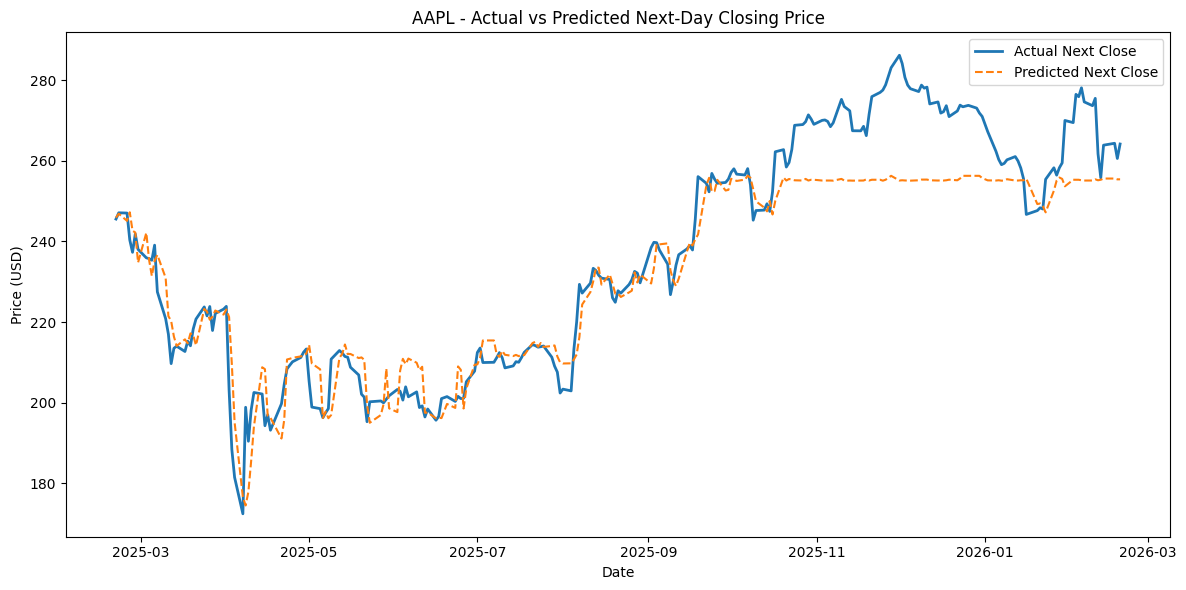

In [123]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(dates, actual, label="Actual Next Close", linewidth=2)
plt.plot(
    dates, predicted, label="Predicted Next Close", linestyle="--"
)
plt.title(f"{ticker} - Actual vs Predicted Next-Day Closing Price")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.tight_layout()
plt.show()